Youtube Comments Summarizer  Pipeline:

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from haystack import Pipeline
from haystack.components.builders import PromptBuilder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever, InMemoryBM25Retriever
from haystack.components.writers import DocumentWriter
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.converters import OutputAdapter

from haystack_integrations.components.embedders.cohere import CohereDocumentEmbedder, CohereTextEmbedder

from src.custom_components.components import ReviewData


None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [3]:
CSV_PATH = "comments-2024-08-31 22:51:22.924448.csv"

CSV_PATH2 = "comments-2024-09-06 00:57:45.840294.csv"

In [4]:
review_data = ReviewData()

output = review_data.run(csv_file_path=CSV_PATH)
output["reviews"]

[{'author': '@user-jz4oz3bx3n',
  'comment': 'her lyrics are so unserious  I LOOOVE IT'},
 {'author': '@Bentleytee',
  'comment': '1:02 “come right on me, I mean camaraderie” okay girl you deserve album of the year.'},
 {'author': '@j_localxxo',
  'comment': "come right on me. i mean camaraderie she's so unserious i love her . but the song is really good too "},
 {'author': '@SwitchxZ0NE',
  'comment': "This song makes me feel like I'm part of a retro summer movie and I LOVE IT"},
 {'author': '@lehhe1818',
  'comment': "who's the cute boy with the white jacket and the thick accent? IS SO GOOOOOOOD"},
 {'author': '@DeffNotScar',
  'comment': 'THE BEAT IS SO EARLY 2000s - 90s \r\nI LOVE YOUUUUU'},
 {'author': '@summerwine85',
  'comment': 'witty lyrics and a catchy beat define Sabrina. this is peak lyricism, and i love how she delivers it so nonchalantly'},
 {'author': '@aasthamehra6544',
  'comment': 'Barry needs to be in the official mv of this song. Period'},
 {'author': '@livinitupwi

In [5]:
output["reviews"].extend(review_data.run(csv_file_path=CSV_PATH2)["reviews"])
output["reviews"]

[{'author': '@user-jz4oz3bx3n',
  'comment': 'her lyrics are so unserious  I LOOOVE IT'},
 {'author': '@Bentleytee',
  'comment': '1:02 “come right on me, I mean camaraderie” okay girl you deserve album of the year.'},
 {'author': '@j_localxxo',
  'comment': "come right on me. i mean camaraderie she's so unserious i love her . but the song is really good too "},
 {'author': '@SwitchxZ0NE',
  'comment': "This song makes me feel like I'm part of a retro summer movie and I LOVE IT"},
 {'author': '@lehhe1818',
  'comment': "who's the cute boy with the white jacket and the thick accent? IS SO GOOOOOOOD"},
 {'author': '@DeffNotScar',
  'comment': 'THE BEAT IS SO EARLY 2000s - 90s \r\nI LOVE YOUUUUU'},
 {'author': '@summerwine85',
  'comment': 'witty lyrics and a catchy beat define Sabrina. this is peak lyricism, and i love how she delivers it so nonchalantly'},
 {'author': '@aasthamehra6544',
  'comment': 'Barry needs to be in the official mv of this song. Period'},
 {'author': '@livinitupwi

In [6]:
from haystack import Document

docs = []

for review in output['reviews']:
    docs.append(Document(content=review['comment']))

In [7]:
document_store = InMemoryDocumentStore()

embedder = CohereDocumentEmbedder(model="embed-english-v3.0")
writer = DocumentWriter(document_store=document_store)

indexing = Pipeline()
indexing.add_component("embedder", embedder)
indexing.add_component("writer", writer)

indexing.connect("embedder", "writer")


🚅 Components
  - embedder: CohereDocumentEmbedder
  - writer: DocumentWriter
🛤️ Connections
  - embedder.documents -> writer.documents (List[Document])

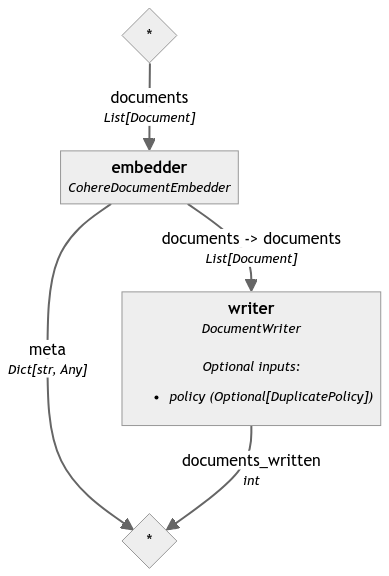

In [8]:
indexing.show()

In [9]:
dialogue1 = indexing.run({"embedder": {"documents":docs}})

print(dialogue1)

Calculating embeddings: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]

{'embedder': {'meta': ApiMeta(api_version=ApiMetaApiVersion(version='1', is_deprecated=None, is_experimental=None), billed_units=ApiMetaBilledUnits(input_tokens=513.0, output_tokens=None, search_units=None, classifications=None), tokens=None, warnings=[])}, 'writer': {'documents_written': 14}}


In [10]:

print(indexing.dumps())

components:
  embedder:
    init_parameters:
      api_base_url: https://api.cohere.com
      api_key:
        env_vars:
        - COHERE_API_KEY
        - CO_API_KEY
        strict: true
        type: env_var
      batch_size: 32
      embedding_separator: '

        '
      input_type: search_document
      meta_fields_to_embed: []
      model: embed-english-v3.0
      progress_bar: true
      timeout: 120
      truncate: END
      use_async_client: false
    type: haystack_integrations.components.embedders.cohere.document_embedder.CohereDocumentEmbedder
  writer:
    init_parameters:
      document_store:
        init_parameters:
          bm25_algorithm: BM25L
          bm25_parameters: {}
          bm25_tokenization_regex: (?u)\b\w\w+\b
          embedding_similarity_function: dot_product
          index: bad2ba28-fe25-46b5-95a5-63b8a7dff25a
        type: haystack.document_stores.in_memory.document_store.InMemoryDocumentStore
      policy: NONE
    type: haystack.components.writer

In [11]:
from haystack_integrations.components.generators.amazon_bedrock import AmazonBedrockGenerator

generator = AmazonBedrockGenerator(
        model="amazon.titan-text-lite-v1",
        max_length=99
)

In [12]:
template = """You will be provided a few of the top comments for a youtube video. Based on the comments, Summerize what people think sabrina's new music video.
Comments:  
{% for review in reviews %}
  Comment:\n
  {{ review['author'] }} wrote {{ review['comment'] }}
{% endfor %}  
"""
prompt1 = PromptBuilder(template=template)

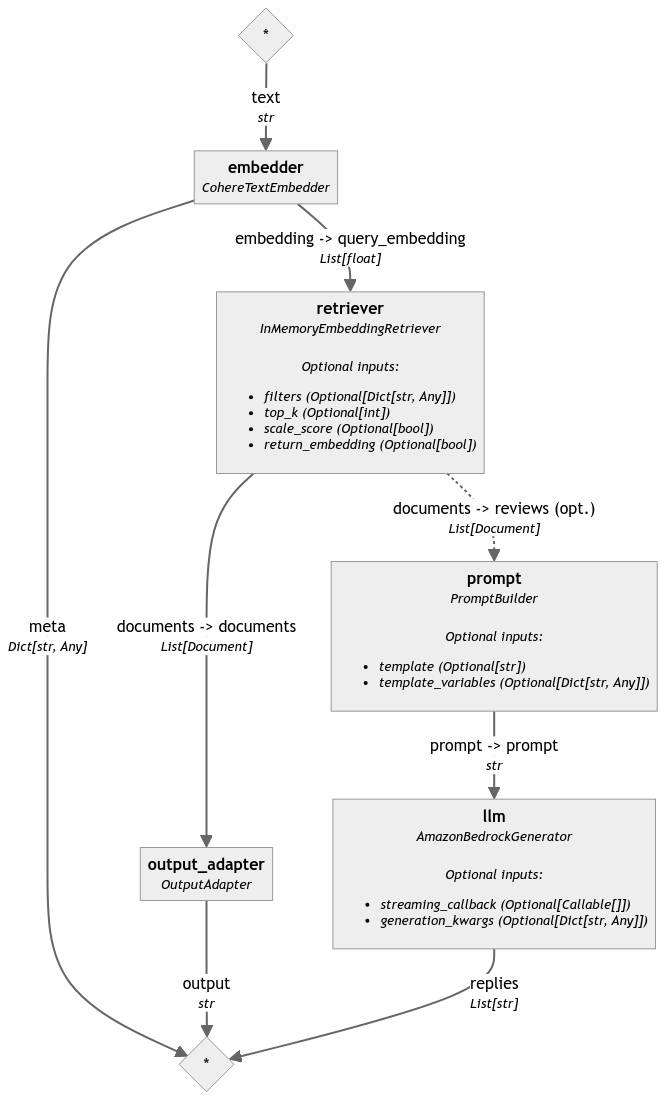

In [13]:

prompt1 = PromptBuilder(template=template)
retriever = InMemoryEmbeddingRetriever(document_store)
embedder = CohereTextEmbedder(model="embed-english-v3.0")

dialogue_builder1 = Pipeline()
dialogue_builder1.add_component("embedder", embedder)
dialogue_builder1.add_component("retriever", retriever)
dialogue_builder1.add_component(
    name="output_adapter",
    instance=OutputAdapter(template="{{ documents }}", output_type=str),
)
dialogue_builder1.add_component("prompt", prompt1)
dialogue_builder1.add_component("llm", generator)

dialogue_builder1.connect("embedder.embedding", "retriever.query_embedding")
dialogue_builder1.connect("retriever.documents", "prompt.reviews")
dialogue_builder1.connect("retriever.documents", "output_adapter")
dialogue_builder1.connect("prompt", "llm")

dialogue_builder1.outputs(True)

dialogue_builder1.show()

In [19]:
question = "Summerize what people think sabrina's new music video."
dialogue1 = dialogue_builder1.run({"retriever": {"top_k": 8}, "embedder": {"text":question}})

print(dialogue1["llm"]["replies"])



["The comments suggest that Sabrina Carpenter's new music video is a colorful and vibrant celebration of individuality and self-expression. The video features a diverse range of dancers and performers, showcasing their unique styles and movements. The use of bright colors and vibrant lighting creates a visually stunning and energetic atmosphere. The choreography is intricate and dynamic, with each dancer bringing their own personality to the performance. The video also includes a message of self-love and acceptance, encouraging viewers to be true to themselves and embrace"]


In [20]:
print(dialogue1["output_adapter"]["output"])

[Document(id=7cb0e286dc48116986d017e6518ebfb201c21b5fea6469cf5b8c07b94239939d, content: 'witty lyrics and a catchy beat define Sabrina. this is peak lyricism, and i love how she delivers it...', score: 0.47794328286193893), Document(id=145ec01a3de7853cd29bd6780b98f25fc8ab1eb9f449a6540a16a00990ec225d, content: 'This song makes me feel like I'm part of a retro summer movie and I LOVE IT', score: 0.35102311546440973), Document(id=018f546d3c218e366dd04d5ca766539207aafa4b20ba76f9a45113acd0ad8a35, content: 'her lyrics are so unserious  I LOOOVE IT', score: 0.31077885039121045), Document(id=abf62f2aedce49c976ea58ba8df2cb0c768383f3a9e21366da7536183eab0187, content: 'Barry needs to be in the official mv of this song. Period', score: 0.28989642276409217), Document(id=57db98459e255cf30bd06a012e811dc5f7529bd856a5d9ad474a79b61716c187, content: 'come right on me. i mean camaraderie she's so unserious i love her . but the song is really good too...', score: 0.26952586864756656), Document(id=349ec2db0

In [15]:
print(dialogue_builder1.dumps())

components:
  embedder:
    init_parameters:
      api_base_url: https://api.cohere.com
      api_key:
        env_vars:
        - COHERE_API_KEY
        - CO_API_KEY
        strict: true
        type: env_var
      input_type: search_query
      model: embed-english-v3.0
      timeout: 120
      truncate: END
      use_async_client: false
    type: haystack_integrations.components.embedders.cohere.text_embedder.CohereTextEmbedder
  llm:
    init_parameters:
      aws_access_key_id:
        env_vars:
        - AWS_ACCESS_KEY_ID
        strict: false
        type: env_var
      aws_profile_name:
        env_vars:
        - AWS_PROFILE
        strict: false
        type: env_var
      aws_region_name:
        env_vars:
        - AWS_DEFAULT_REGION
        strict: false
        type: env_var
      aws_secret_access_key:
        env_vars:
        - AWS_SECRET_ACCESS_KEY
        strict: false
        type: env_var
      aws_session_token:
        env_vars:
        - AWS_SESSION_TOKEN
      